# Example: Salt tectonics with variable thermal diffusivity

NÃO ESQUECER DE MUDAR O NOME DO CENARIO!

## Generate input files

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pandas as pd
import numpy as np

basin_above = False              #Moho fixa e bacia em cima
crust_thick_cte = True         #Espessura da crosta constante -> desligar se for por a bacia em cima
visc_basin_cte = False   #Viscosidade dos sedimentos na bacia constante
kappa_cte = False        #Kappa constante para o sedimento
kappa_cr_cte = False #kappa de todas as camadas abaixo da crosta são cte

In [25]:
msnow = str(datetime.now())[-6:-1] #microsecs
tempdir = f'temp_{msnow}'
os.mkdir(tempdir)
os.chdir(tempdir)

### Shape of the model

In [26]:
# Horizontal and vertical extent of the model in meters:
Lx, Lz = 1200.0e3, 300.0e3

# Number of points in horizontal and vertical direction:
Nx, Nz = 1201, 301 #1201, 601      #grid of 500m

In [27]:
x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)

X, Z = np.meshgrid(x, z)

### Define the thickness of the layers

They are in meters.

In [21]:
#### Sticky air layer:
t_sa = 40.0e3

# sediments:
t_sed = 1.0e3

# salt:
t_salt = 0.0e3

# total crust:
t_crust = 40.0e3

# Lower crust:
t_lower_crust = t_crust/2

# Upper crust:
t_upper_crust = t_crust/2

# Lithosphere:
t_litho = 130.0e3

if basin_above==True:
    t_sa = t_sa-t_sed

#para manter a base da crosta na mesma profundidade
if crust_thick_cte==True:
  t_lower_crust = (t_crust-t_salt-t_sed)/2
  t_upper_crust = (t_crust-t_salt-t_sed)/2

elif basin_above==True:
  t_lower_crust = (t_crust)/2
  t_upper_crust = (t_crust)/2
  t_sa = t_sa - t_sed

#para colocar a weak seed no sedimento só se ele for mais espesso que a célula
insert_sed_seed=True if t_sed > 500 else False


#Configurando a seed na rocha
seed_depth = 13.0e3     #m - profundidade da seed
thickness_seed = 6.0e3  #m - espessura da camada seed
x_seed = Lx//3          #m - posição horizontal da seed
n_seed = 2              #m - numero de seed em x

lambda_sed = 100.0e3
A_sed = 500.0 if t_salt > 0 else 0


seeds_coords = [[x_seed],[seed_depth+t_lower_crust+t_upper_crust+t_sa]]

#Configurando a seed na camada sedimentar
if insert_sed_seed==True:
  sed_seed_depth = t_sed/2  #m - profundidade da seed
  sed_thickness_seed = 0.750e3  #m - espessura da camada seed
  sed_x_seed = Lx//3          #m - posição horizontal da seed
  sed_n_seed = 4              #m - numero de seed em x

  sed_seed_depth = sed_seed_depth-500 if t_sed/1e3 % 2 == 0 else sed_seed_depth #pra não sobrepor com a camada sedimentar de 1 km
  seeds_coords[0].append(sed_x_seed)
  seeds_coords[1].append(sed_seed_depth+t_sa)

print(f'Crust: {t_lower_crust+t_upper_crust} m')
print(f'Basin: {t_salt+t_sed} m')


Crust: 39000.0 m
Basin: 1000.0 m


### Create the interfaces (bottom first)

In [22]:
if basin_above==False:
    interfaces = {
        "litho": np.ones(Nx) * (t_litho + t_sa),
        "seed_base"   : np.ones(Nx)*(seed_depth+t_lower_crust+t_upper_crust+t_sa),
        "seed_top"    : np.ones(Nx)*(seed_depth+t_lower_crust+t_upper_crust+t_sa),
        "lower_crust": np.ones(Nx) * (t_lower_crust + t_upper_crust + t_salt + t_sed + t_sa),
        "upper_crust": np.ones(Nx) * (t_upper_crust + t_salt + t_sed + t_sa),
      }

else:
    interfaces = {
    "litho": np.ones(Nx) * (t_litho + t_sa),
    "seed_base"   : np.ones(Nx)*(seed_depth+t_lower_crust+t_upper_crust+t_sa),
    "seed_top"    : np.ones(Nx)*(seed_depth+t_lower_crust+t_upper_crust+t_sa),
    "lower_crust": np.ones(Nx) * (t_lower_crust + t_upper_crust + t_sed+t_sa),
    "upper_crust": np.ones(Nx) * (t_upper_crust + t_sed + t_sa),
  }

interfaces["salt_base"] = np.ones(Nx) *   (t_salt + t_sed + t_sa)
sed_base = (t_sed + t_sa)
sed_layers=np.arange(sed_base, t_sa, -1000)

c=0
inserted_sed_seed = False #seed não inserida
for l in sed_layers:

  if l-t_sa <= sed_seed_depth and insert_sed_seed==True: #se a profundidade for menor igual E inserir a weak seed
    interfaces['sed_seed_base'] = np.ones(Nx)*(t_sa + sed_seed_depth)
    interfaces['sed_seed_top'] = np.ones(Nx)*(t_sa + sed_seed_depth)
    insert_sed_seed=False #não inserir mais weak seed
    inserted_sed_seed = True #weak seed inserida

  elif insert_sed_seed==True and l-t_sa <= min(sed_layers-t_sa): #Se inserir a ws E a profundidade
    interfaces['sed_seed_base'] = np.ones(Nx)*(t_sa + sed_seed_depth)
    interfaces['sed_seed_top'] = np.ones(Nx)*(t_sa + sed_seed_depth)
    insert_sed_seed=False #não inserir mais weak seed
    inserted_sed_seed = True #weak seed inserida

  salt_waves = A_sed*np.sin(x*2*np.pi/lambda_sed) if c==0 else 0 #plotar ondulação no sal na primeira camada

  interfaces[f'sed{c}'] = np.ones(Nx) * (l+salt_waves)
  c+=1

interfaces["air"]= np.ones(Nx) * (t_sa)

#sedimento
if inserted_sed_seed==True: #se inserida
  pos_i = int(Nx * (sed_x_seed/Lx) - sed_n_seed//2)
  pos_f = int(Nx * (sed_x_seed/Lx) + sed_n_seed//2)
  interfaces['sed_seed_base'][pos_i:pos_f] = interfaces['sed_seed_base'][pos_i:pos_f] + sed_thickness_seed//2
  interfaces['sed_seed_top'][pos_i:pos_f] = interfaces['sed_seed_top'][pos_i:pos_f] - sed_thickness_seed//2

#crosta
pos_i = int(Nx * (x_seed/Lx) - n_seed//2)
pos_f = int(Nx * (x_seed/Lx) + n_seed//2)
interfaces['seed_base'][pos_i:pos_f] = interfaces['seed_base'][pos_i:pos_f] + thickness_seed//2
interfaces['seed_top'][pos_i:pos_f] = interfaces['seed_top'][pos_i:pos_f] - thickness_seed//2



Plot the interfaces:

In [23]:
#The color below the inferface!
cr = 255.0
'''
colors = {
'air' : (225.0 / cr, 222.0 / cr, 112.0 / cr),
'sed0' : (217.0 / cr, 139.0 / cr, 255.0 / cr),
'salt_base' : (228.0 / cr, 156.0 / cr, 124.0 / cr),
'upper_crust' : (240.0 / cr, 209.0 / cr, 188.0 / cr),
'lower_crust' : (155.0 / cr, 194.0 / cr, 155.0 / cr),
'litho' : (207.0 / cr, 226.0 / cr, 205.0 / cr)
}
'''

color_sed = (246.0 / cr, 200.0 / cr, 6.0 / cr)
color_upper_crust = (165.0 / cr, 163.0 / cr, 238.0 / cr)
color_lower_crust = (227.0 / cr, 217.0 / cr, 242.0 / cr)
color_lithosphere = (155.0 / cr, 194.0 / cr, 155.0 / cr)
color_asthenosphere = (207.0 / cr, 226.0 / cr, 205.0 / cr)

colors = {
'air' : color_sed,
'sed0' : '#dc92e0',
'salt_base' : color_upper_crust,
'upper_crust' : color_lower_crust,
'lower_crust' : color_lithosphere,
'litho' : color_asthenosphere
}

correct_labels = {
'air' : 'Sediment',
'sed0' : 'Salt',
'salt_base' : 'Upper crust',
'upper_crust' : 'Lower crust',
'lower_crust' : 'Lithospheric mantle',
'litho' : 'Asthenosphere'
}

if t_salt < 500 and t_sed==0:
  correct_labels['air'] = correct_labels['salt_base']
  colors['air'] = colors['salt_base']

elif t_salt < 500:
  correct_labels['sed0']=correct_labels['salt_base']
  colors['sed0']=colors['salt_base']

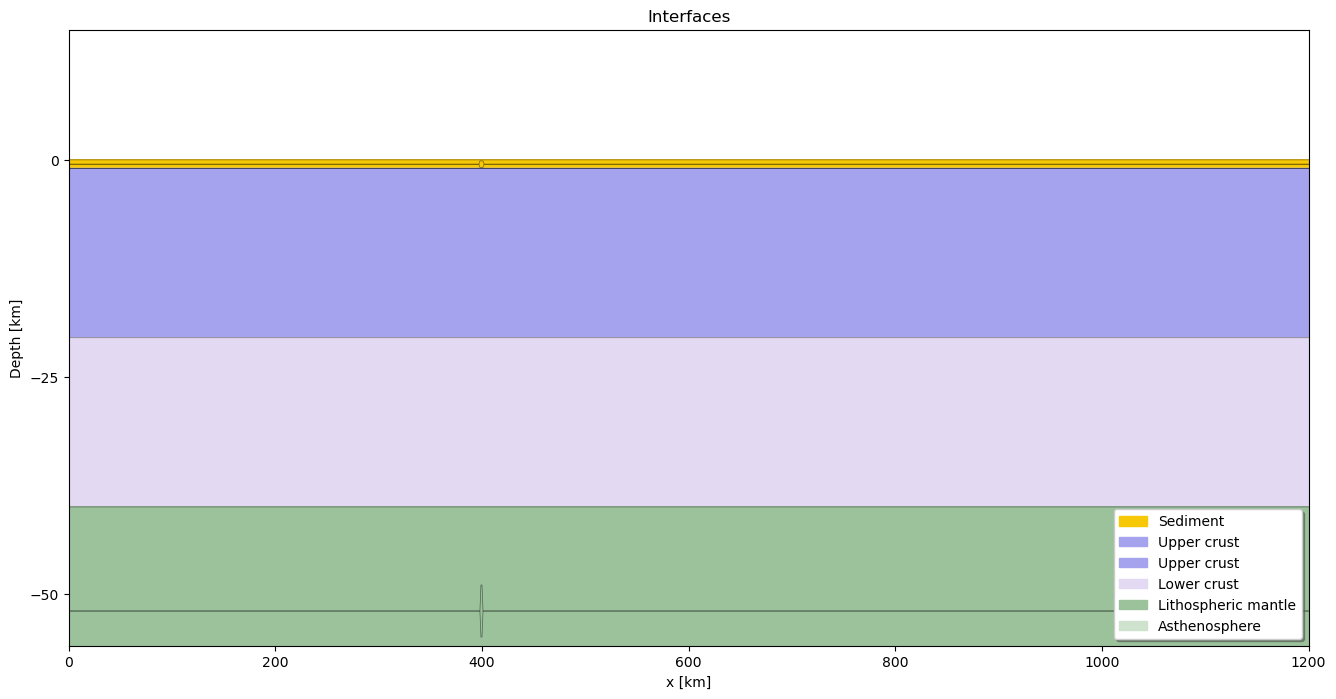

In [24]:
fig, ax = plt.subplots(figsize=(16, 8))

for ll in list(interfaces.items())[::-1]:
    label, layer = ll[0], ll[1]
    if basin_above==False:
        ax.plot(x / 1e3, (-layer) / 1e3 + t_sa/1e3, '-k',lw=0.5,alpha=0.5)
    else:
        ax.plot(x / 1e3, (-layer) / 1e3 + t_sa/1e3, '-k',lw=0.5,alpha=0.5) 
    if 'seed' not in label:
      if ('sed' in label) and (label!='sed0'):
        label='air'
        continue

      ax.fill_between(x/1e3, (-layer) / 1e3+ t_sa/1e3, -Lz/1e3 + t_sa/1e3,color=colors[label],label=correct_labels[label])


ax.set_yticks(np.arange(-Lz / 1e3, 1 / 1e3, 25))
ax.set_xlim([0, Lx/1000])
ax.set_ylim([-(Lz) / 1e3, 0 / 1e3])
ax.set_ylim([-56000 / 1e3, 15000 / 1e3])

ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

plt.title("Interfaces")
plt.legend(loc='lower right',shadow=True)

plt.show()


#### Create the interface file

The interface file contain the layer properties and the interface's depth between these layers.

Layer properties:
* Compositional factor (C)
* Density (rho)
* Radiogenic heat (H)
* Pre-exponential scale factor (A)
* Power law exponent (n)
* Activation energy (Q)
* Activation volume (v)
* Thermal diffusivity (k)

In [11]:
#Salt Params from Massimi (2007), Andrés-Martínez et al. (2019) and Pitchel et al. (2022)
#doi.org/10.1016/j.cma.2007.08.004
#doi.org/10.1029/2021TC007158



#Salt properties
rho_salt = 2200.0          #kg/m³  (density)
visc_salt = 1.0e-18       #Pa.s (viscosity)
Hsalt = 0 #0.8e-6/rho_salt  #W/kg   (radiogec heat production)
Q_salt = 2.0e4          #J/mol  (activation energy)
V_salt = 4.0e-6          #m³/mol (activation volume)
n_salt = 1.7             # --    (power-law of viscosity)
k_salt = 6.5             #W/mK   (thermal conductivity)


#sediment properties
rho_sed = 2500.0          #kg/m³   (sed. density)
visc_sed = 1.0e-24        #Pa.s    (effective viscosity?)
Hsed = 1.3e-6 / rho_sed     #(sed. radiogenic heat prod.)
n_sed = 4
Q_sed = 222.0e3
A_sed = 8.574e-28
cmax_sed = 10e+6
cmin_sed = 4e+6
fmin_sed = 2
fmax_sed = 15


#deixar o sal constante
Q_salt = 0           #J/mol  (activation energy)
V_salt = 0          #m³/mol (activation volume)
n_salt = 1             # --    (power-law of viscosity)

#k = 2.5 in sedimentary basins represents a layer of siltstone

#Thermal properties
kp_sed = 1.5/(rho_sed*818.2)   #sandstone:2.5; shale: <1.1
kp_salt = k_salt/(rho_salt*803.6)   #between 2e-6 to 6e-6 m²/s
kp_uc = 2.5/(2700*818.2)
kp_lc = 2.5/(2800*775.8)
kp_man = 3.3/(3360*681.81)
kp_air = 1e-5

if kappa_cr_cte==True:
  kp_salt = 1e-6   #between 2e-6 to 6e-6 m²/s
  kp_uc = 1e-6
  kp_lc = 1e-6
  kp_man = 1e-6
  kp_air = 1e-6

if kappa_cte==True:
    kp_sed = 1e-6   #sandstone:2.5; shale: 1.1


In [12]:
#Para montar o arquivo de interfaces
saltprops = {'C':'1.0',  'rho': f'{rho_salt}',  'H': f'{Hsalt}', 'A': f'{visc_salt}', 'n': f'{n_salt}',
            'Q': f'{Q_salt}',     'V': f'{V_salt}', 'k': f'{kp_salt}', 'cmin' : '4e+6', 'cmax':'20e+6',
            'fmin' :'2', 'fmax':'15', 'wseed':'0.0'}

(-10.0, 0.0)

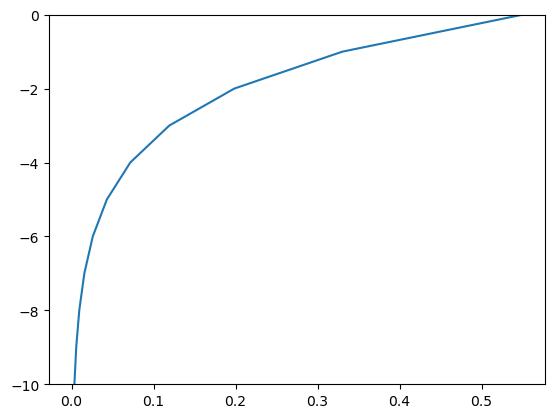

In [13]:
#Ploting the density of sediment as function of porosity (depth)
def phi(depth, phi0=0.55, c=0.51): #allen and allen, pg 356
  return phi0*np.exp(-c*depth)

plt.plot(phi(z/1e3),-z/1e3)
plt.ylim(-10,0)

In [14]:
sedprops = {'prof': '',  'C':'',  'rho': '',  'H': '', 'A': '', 'n': '',
            'Q': '',     'V': '', 'k': '', 'cmin' : '', 'cmax':'',
            'fmin' :'', 'fmax':'', 'wseed':''}

if t_sed>0:
  sed_weak_array = (sed_layers-t_sa)
  if inserted_sed_seed==True:
    sed_weak_array = np.append(sed_weak_array, [sed_seed_depth,sed_seed_depth-1])
  profs = np.sort(sed_weak_array)

  r = []
  param_seed_inserted = False #variavel pra ver se a seed ja foi inserida

  for l in profs[::-1]:
    sedprops['prof'] += f'{l} '


    its_the_seed = True if (param_seed_inserted == False) and (l==sed_seed_depth) else False #a camada é a seed se ela não foi inserida e tem a mesma profundidade
    param_seed_inserted = True if its_the_seed==True else False #a seed foi inserida

    c = 1.0 if its_the_seed==False else 0.1
    wseed = -1.0  if its_the_seed==False else 0.5
    sedprops['wseed'] += f'{wseed} '
    sedprops['C'] += f'{c} '

    #rho
    porosity = phi(l/1e3)
    rholayer = rho_sed * (1-porosity) + 1000 * porosity
    sedprops['rho'] += f'{rholayer}  '
    r.append(rholayer)

    #rest of the properties
    sedprops['A'] += f'{A_sed} '
    sedprops['H'] += f'{Hsed}  '
    sedprops['n'] += f'{n_sed}  '
    sedprops['Q'] += f'{Q_sed}  '
    sedprops['V'] += f'{V_salt}  '
    sedprops['k'] += f'{kp_sed}  '
    sedprops['cmin'] += f'{cmin_sed}  '
    sedprops['cmax'] += f'{cmax_sed}  '
    sedprops['fmin'] += f'{fmin_sed}  '
    sedprops['fmax'] += f'{fmax_sed}  '




  plt.plot(r, -profs[::-1])
  plt.ylabel('z (m)')
  plt.xlabel('$ \\rho_{sed}$ (kg/m³)')

In [15]:
#Caso não haja sal e/ou sedimento:
if t_salt==0:
  salt_intparams = list(saltprops.keys())
  for p in salt_intparams:
    saltprops[p] = ''

if t_sed==0:
  sed_intparams = list(sedprops.keys())
  for p in sed_intparams:
    sedprops[p] = ''


In [16]:
# Define the radiogenic heat for the upper and lower crust in W/kg:
Hsed = 1.3e-6 / rho_sed     #(sed. radiogenic heat prod.)
Huc = 2.5e-6 / 2700.0
Hlc = 0.8e-6 / 2800.0

dic_params = {}
# PRECISA TER 1 LINHA DE PARAMETROS A MAIS DO QUE DE INTERFACES!!!!!
# Create and save the interface file:
with open("interfaces.txt", "w") as f:
  #Astenosfera - Manto - Seed - Manto - Crosta inferior - Crosta superior - Sal - Sedimento - Sed Seed - Sedimento - Ar
  layer_properties = f"""
    C   1.0       1.0        0.1        1.0         1.0         1.0         {saltprops['C']}      {sedprops['C']}     1.0
    rho 3378.0    3354.0     3354.0     3354.0      2800.0      2700.0      {saltprops['rho']}    {sedprops['rho']}   1.0
    H   0.0       9.0e-12    9.0e-12    9.0e-12     {Hlc}       {Huc}       {saltprops['H']}      {sedprops['H']}     0.0
    A   1.393e-14 2.4168e-15 2.4168e-15 2.4168e-15  8.574e-28   8.574e-28   {saltprops['A']}      {sedprops['A']}     1.0e-18
    n   3.0       3.5        3.5        3.5         4.0         4.0         {saltprops['n']}      {sedprops['n']}     1.0
    Q   429.0e3   540.0e3    540.0e3    540.0e3     222.0e3     222.0e3     {saltprops['Q']}      {sedprops['Q']}     0.0
    V   15.0e-6   25.0e-6    25.0e-6    25.0e-6     0.0         0.0         {saltprops['V']}      {sedprops['V']}     0.0
    k   {kp_man}  {kp_man}   {kp_man}  {kp_man}    {kp_lc}     {kp_uc}      {saltprops['k']}      {sedprops['k']}     {kp_air}
    weakening_seed 0.0    -1.0 1.0     -1.0        -1.0        -1.0         {saltprops['wseed']}  {sedprops['wseed']} -1.0
    cohesion_min  4e+6   4e+6  4e+6     4e+6        4e+6        4e+6        {saltprops['cmin']}   {sedprops['cmin']}  4e+6
    cohesion_max  20e+6  20e+6  20e+6   20e+6       20e+6       20e+6       {saltprops['cmax']}   {sedprops['cmax']}  20e+6
    friction_angle_min  2   2     2     2           2           2           {saltprops['fmin']}   {sedprops['fmin']}  2
    friction_angle_max  15  15    15    15          15          15          {saltprops['fmax']}   {sedprops['fmax']}  15
  """

  for line in layer_properties.split("\n"):
      line = line.strip()
      if len(line):
        dic_params[line.split()[0]] = np.array(line.split()[1:]).astype(np.float32)

        f.write(" ".join(line.split()) + "\n")


  # layer interfaces
  data = -1 * np.array(tuple(interfaces.values())).T
  np.savetxt(f, data, fmt="%.1f")

dfparams = pd.DataFrame(dic_params)
dfparams


,C,rho,H,A,n,Q,V,k,weakening_seed,cohesion_min,cohesion_max,friction_angle_min,friction_angle_max
0,1.0,3378.0,0.000000e+00,1.393000e-14,3.0,429000.0,0.000015,0.000001,0.0,4000000.0,20000000.0,2.0,15.0
1,1.0,3354.0,9.000000e-12,2.416800e-15,3.5,540000.0,0.000025,0.000001,-1.0,4000000.0,20000000.0,2.0,15.0
2,0.1,3354.0,9.000000e-12,2.416800e-15,3.5,540000.0,0.000025,0.000001,1.0,4000000.0,20000000.0,2.0,15.0
3,1.0,3354.0,9.000000e-12,2.416800e-15,3.5,540000.0,0.000025,0.000001,-1.0,4000000.0,20000000.0,2.0,15.0
4,1.0,2800.0,2.857143e-10,8.574000e-28,4.0,222000.0,0.000000,0.000001,-1.0,4000000.0,20000000.0,2.0,15.0
5,1.0,2700.0,9.259259e-10,8.574000e-28,4.0,222000.0,0.000000,0.000001,-1.0,4000000.0,20000000.0,2.0,15.0
6,1.0,1.0,0.000000e+00,1.000000e-18,1.0,0.0,0.000000,0.000010,-1.0,4000000.0,20000000.0,2.0,15.0


### Create initial temperature field

The initial temperature structure is depth dependent and is 0°C at the surface and 1300°C at the base of the lithosphere at 130 km.
With these boundary conditions, the initial temperature structure in the interior of the lithosphere is given by the solution of the following equation:

$$ \kappa \frac{\partial^2 T(z)}{\partial z^2} + \frac{H(z)}{c_p} = 0$$

where $H(z)$ is the internal heat production of the different layers.

The sublithospheric temperature follows an adiabatic increase up to the bottom of the model:

$$T = T_p exp (g \alpha z ∕c_p)$$

Where $T_p$ is the potential temperature for the mantle, $g$ is the gravity aceletation, $\alpha$ is the volumetric expansion coefficient, $c_p$ is the specific heat capacity.

In [15]:
kappa = 1.0e-6 # m^2/s
ccapacity = 1250 # J/(kg K)
tem_p = 1262  # °C
g = -10 # m/s^2
alpha = 3.28e-5 # 1/K

In [16]:
# Temperature when z < 130 km:
temp_z = 1300 * (z - t_sa) / (t_litho)

# Sublithospheric temperature:
temp_adiabatic = tem_p / np.exp(g * alpha * (z - t_sa) / ccapacity)

temp_z[temp_z < 0.0] = 0.0
temp_z[temp_z > temp_adiabatic] = temp_adiabatic[temp_z > temp_adiabatic]
temp_z = np.float64(temp_z)

Now, we will apply the thermal diffusivity in the model.

Create the internal heat production model:

(-260.0, 10.0)

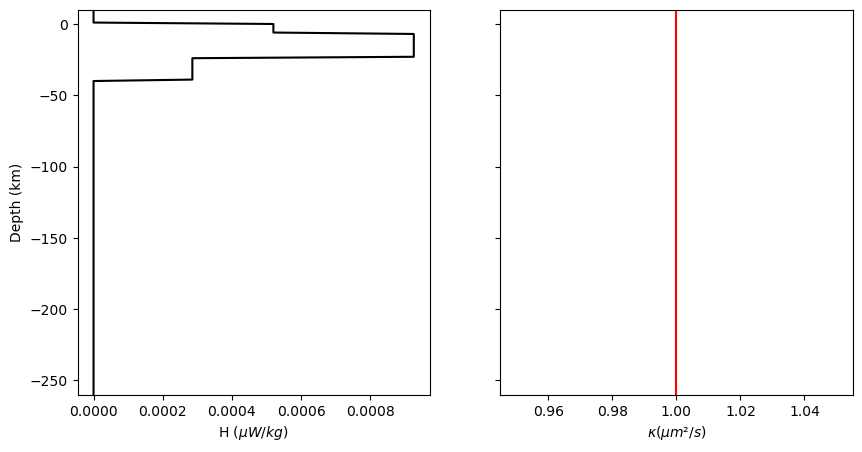

In [17]:
H = np.zeros_like(temp_z)
KP = np.zeros_like(temp_z)
KP = KP.astype(np.float64)

if t_sed>0:
  # Add the H value to the sediment:
  cond = (z >= t_sa) & (
      z < t_sed + t_sa
  )   # lower crust
  H[cond] = Hsed
  KP[cond] = np.round(kp_sed,8)

if t_salt>0:
  # Add the H value to the salt:
  cond = (z >= t_sed + t_sa) & (
      z < t_salt + t_sed + t_sa
  )   # lower crust
  H[cond] = Hsalt
  KP[cond] = np.round(kp_salt,8)

# Add the H value for the upper crust:
cond = (z >= t_sed+t_salt+t_sa) & (z < t_sed+t_salt+t_upper_crust + t_sa)
H[cond] = Huc
KP[cond] = np.round(kp_uc,8)

# Add the H value for the lower crust:
cond = (z >= t_sed+t_salt+t_upper_crust + t_sa) & (
    z < t_sed+t_salt+t_lower_crust + t_upper_crust + t_sa
)   # lower crust
H[cond] = Hlc
KP[cond] = np.round(kp_lc,8)

KP[z>=t_sed+t_salt+t_upper_crust + t_sa + t_lower_crust] = np.round(kp_man,8)
KP[z<=t_sa] = 1e-6

KP[:] = kappa if kappa_cte==True else KP[:]    #Caso kappa seja cte

fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)
axs[0].plot(H[:]/1e-6, -z/1e3+40,'-k')
axs[1].plot(KP[:]/1e-6, -z/1e3+40,'-r')

axs[1].set_xlabel("$ \kappa (\mu m²/s)$")
axs[0].set_xlabel("H $(\mu W/kg)$") #Rad. Heat production
axs[0].set_ylabel("Depth (km)")
axs[0].set_ylim(-(Lz-t_sa)/1e3, 10)


In [18]:
Taux = np.copy(temp_z)
t = 0
dt = 500      #anos: 2000 é bom se for cte, mas é muito grande para difusão variada
dt_sec = dt * 365 * 24 * 3600
cond = (z > t_sa + t_litho) | (temp_z == 0)
dz = Lz / (Nz - 1)

# Apply the thermal diffusivity
while t < 250.0e6:
  try:
    termo1 = np.float64(KP[1:-1]*(temp_z[2:]-temp_z[1:-1])/dz)
    termo2 = np.float64(KP[:-2]*(temp_z[1:-1]-temp_z[:-2])/dz)
    termo12 = dt_sec*( termo1-termo2 )/dz
    termoprod = H[1:-1] * dt_sec / ccapacity
    temp_z[1:-1] += termo12 + termoprod

  except RuntimeWarning:
    print(f'''termo1: {termo1.max()}\n
    termo2: {termo2.max()}\n
    termo12: {termo12.max()}\n
    dz: {dz}''')

  '''
    temp_z[1:-1] += (
        kappa * dt_sec * ((temp_z[2:] + temp_z[:-2] - 2 * temp_z[1:-1]) / dz ** 2)
        + H[1:-1] * dt_sec / ccapacity
    )

  '''
  temp_z[cond] = Taux[cond]

  t = t + dt

#plt.plot(temp_z,-z/1e3+t_sa/1e3)

Save initial temperature file:

In [19]:
print(temp_z)

temp_z = np.ones_like(X) * temp_z[:,None]

print(np.shape(temp_z))

# Save the initial temperature file
np.savetxt(
    "input_temperature_0.txt",
    np.reshape(temp_z, (Nx * Nz)),
    header="T1\nT2\nT3\nT4"
)

[1351.10363262 1350.74914954 1350.39475946 1350.04046236 1349.68625822
 1349.332147   1348.9781287  1348.62420327 1348.27037071 1347.91663097
 1347.56298405 1347.20942991 1346.85596853 1346.50259989 1346.14932396
 1345.79614072 1345.44305014 1345.0900522  1344.73714687 1344.38433413
 1344.03161396 1343.67898634 1343.32645122 1342.97400861 1342.62165846
 1342.26940075 1341.91723547 1341.56516258 1341.21318206 1340.86129389
 1340.50949805 1340.1577945  1339.80618323 1339.45466421 1339.10323741
 1338.75190282 1338.4006604  1338.04951014 1337.69845201 1337.34748599
 1336.99661205 1336.64583016 1336.29514031 1335.94454246 1335.5940366
 1335.2436227  1334.89330074 1334.54307069 1334.19293253 1333.84288623
 1333.49293177 1333.14306913 1332.79329828 1332.4436192  1332.09403186
 1331.74453625 1331.39513232 1331.04582007 1330.69659947 1330.34747049
 1329.99843311 1329.6494873  1329.30063305 1328.95187032 1328.6031991
 1328.25461936 1327.90613107 1327.55773421 1327.20942876 1326.86121469
 1326.51

array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
       1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06,
      

Plot the temperature model:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


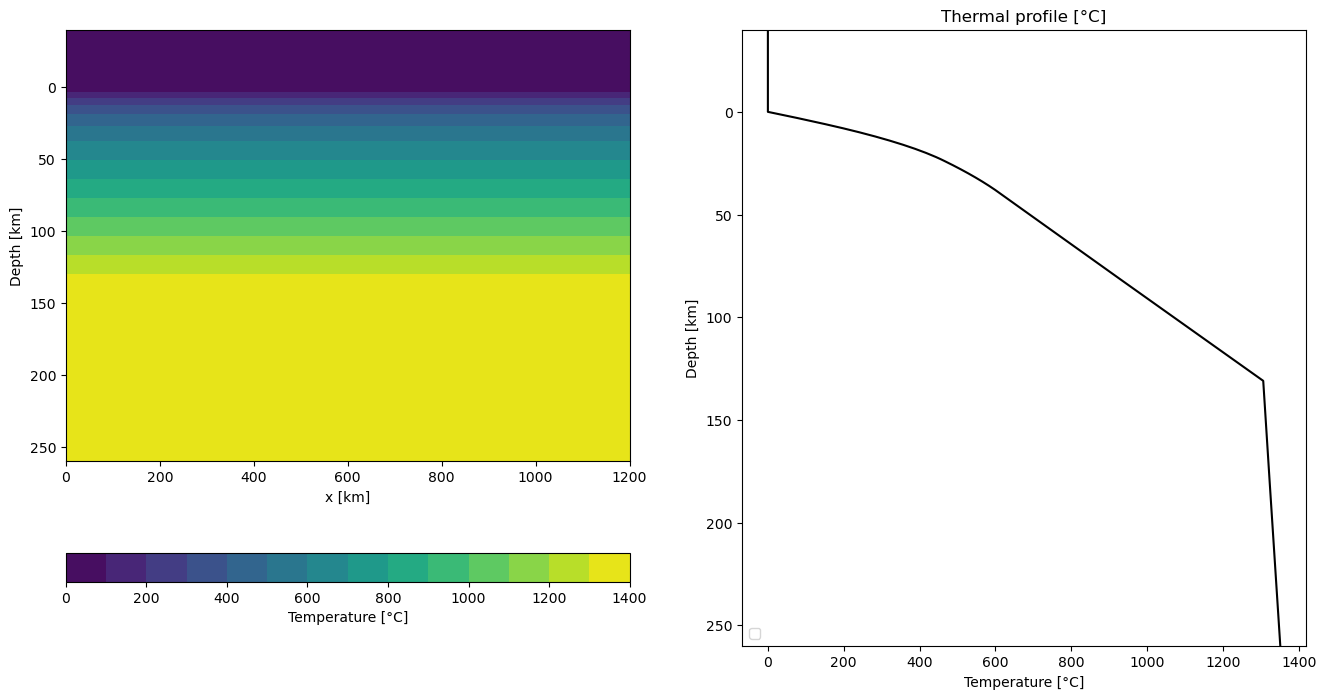

In [21]:
fig2, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Temperature field:
im1 = ax0.contourf(
    X / 1.0e3,
    (Z - t_sa) / 1.0e3,
    temp_z,
    levels=np.arange(0, 1401, 100)
    )

ax0.set_ylim((Lz-t_sa) / 1.0e3, -t_sa / 1e3)
ax0.set_ylabel("Depth [km]")
ax0.set_xlabel("x [km]")
cbar = fig2.colorbar(im1, orientation='horizontal', ax=ax0)
cbar.set_label("Temperature [°C]")

# Profile:
ax1.set_title("Thermal profile [°C]")
ax1.plot(temp_z[:, 0], (z - t_sa) / 1.0e3, "-k")
# Add interfaces:
'''
code = 0
for label in list(interfaces.keys()):
    code += 1
    color = "C" + str(code)
    ax1.hlines(
        (interfaces[label][0] - t_sa) / 1.0e3,
        np.min(temp_z[:, 0]),
        np.max(temp_z[:, 0]),
        label=f"{label}",
        color=color,
    )
'''
ax1.set_ylim((Lz-t_sa) / 1.0e3, -t_sa / 1e3)
ax1.set_xlabel("Temperature [°C]")
ax1.set_ylabel("Depth [km]")

plt.legend(loc="lower left")
plt.show()


### Boundary condition - Velocity

The horizontal velocity field along the left and right borders of the domain presents two layers:
* Constant velocity with depth at $0 ≤ z < h_c$
* Linearly variable velocity with depth at $h_c ≤ z ≤ h_c + h_a$

where $h_c = 150$ km is the thickness of the upper layer with constant velocity, corresponding to the lithosphere $h_{litho} = 130$ km and part of the asthenosphere, and $h_a = 110$ km corresponds to the remaining asthenospheric portion of the model until the bottom
of the model, where the horizontal velocity at the borders of the model varies linearly with depth.
Therefore, the sum $h_c + h_a$ represents the total thickness of the model without the “sticky air” layer.

In [22]:
# Convert 1 cm/year to m/s:
v_rift = 2e-2 / (365 * 24 * 3600)

# Define the thickness with constant velocity in meters
h_c = 150.0e3

t_a = Lz - t_sa - h_c

v = v_rift * (Lz - t_sa) / t_a

fac_air = 10.0e3

In [23]:
# Create  horizontal and vertical velocity:
VX, VZ = np.zeros_like(X), np.zeros_like(X)

Velocity for the left side (`x == 0`):

In [24]:
# When 0 <= z <= (h_v_const + thickness_sa), VX is zero.
# When (h_v_const * thickness_sa) <= z <= Lz, VX goes from 0 to vR.
cond = (Z >= h_c + t_sa) & (X == 0)
VX[cond] += v * (Z[cond] - h_c - t_sa) / t_a

Velocity for the right side (`x == Lx`):

In [25]:
cond = (X == Lx) & (Z <= h_c + t_sa)
VX[cond] += v_rift

# When 0 <= z <= (h_v_const + thickness_sa), VX is 2vL
# When (h_v_const + thickness_sa) < z <= Lz, VX goes from 2vL to -vR + 2vL
cond = (Z > h_c + t_sa) & (X == Lx)
VX[cond] += -v * (Z[cond] - h_c - t_sa) / t_a + v_rift


VX[Z <= t_sa - fac_air] = 0

Due to the mass conservation is assumed, the sum of the integrals over the boundaries (material flow) must be zero.

In [26]:
# For the left side:
v0= VX[(X == 0)]
sum_velocity_left = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0

# For the right side:
vf = VX[(X == Lx)]
sum_velocity_right = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0

dz = Lz / (Nz - 1)
diff = (sum_velocity_right - sum_velocity_left) * dz

print("Sum of the integrals over the boundary is:", diff)


Sum of the integrals over the boundary is: 6.024860476915268e-06


If the sum of the integrals over the boundaries is not zero, because rounding errors, we add a very small flow on the top to compensate this difference.
In fact this is a very small correction.

In [27]:
vv = -diff / Lx

VZ[Z == 0] = vv

Create and save the initial velocity file:

In [28]:
VVX = np.copy(np.reshape(VX, Nx * Nz))
VVZ = np.copy(np.reshape(VZ, Nx * Nz))

velocity = np.zeros((2, Nx * Nz))

velocity[0, :] = VVX
velocity[1, :] = VVZ

velocity = np.reshape(velocity.T, (np.size(velocity)))

np.savetxt("input_velocity_0.txt", velocity, header="v1\nv2\nv3\nv4")

Plot the velocity profile for the boundaries:

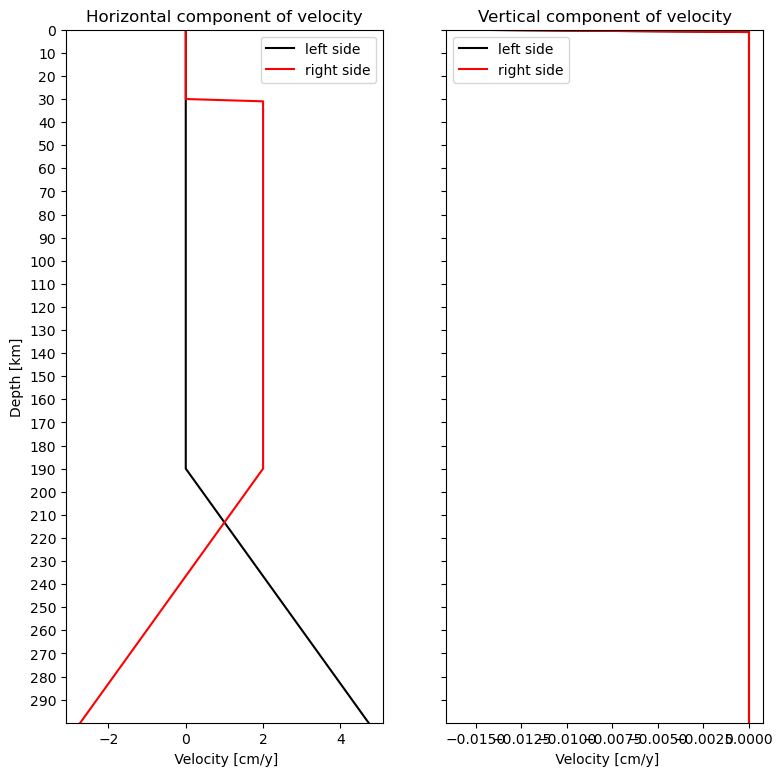

In [29]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9), sharey=True)

ax0.plot(VX[:, 0]* (100*365 * 24 * 3600), (z) / 1e3, "k-", label="left side")
ax1.plot(VZ[:, 0]* (100*365 * 24 * 3600), (z) / 1e3, "k-", label="left side")

ax0.plot(VX[:, -1]* (100*365 * 24 * 3600), (z ) / 1e3, "r-", label="right side")
ax1.plot(VZ[:, -1]* (100*365 * 24 * 3600), (z) / 1e3, "r-", label="right side")

ax0.legend()
ax1.legend()

ax0_xlim = ax0.get_xlim()
ax1_xlim = ax1.get_xlim()

ax0.set_yticks(np.arange(-40, Lz / 1e3, 10))
#ax1.set_yticks(np.arange(0, Lz / 1000, 20))

ax0.set_ylim([Lz / 1e3 , 0])


#ax0.set_xlim([-8e-10, 8e-10])
#ax1.set_xlim([-8e-10, 8e-10])

ax0.set_xlabel(" Velocity [cm/y]")
ax1.set_xlabel(" Velocity [cm/y]")
ax0.set_ylabel("Depth [km]")

ax0.set_title("Horizontal component of velocity")
ax1.set_title("Vertical component of velocity")

plt.show()

### Create the parameter file

In [30]:
#variaveis para o nome do cenarios
#kappa _ esp. sal _ esp. sed. _ base crustal _ vel. _ multicamadas

kpn = 'kc' if kappa_cte else 'kv' #kc = kappa constante; kv = kappa variavel
t_crustn = t_lower_crust + t_upper_crust + t_salt + t_sed
cen = f'{kpn}_{int(t_salt/1e3)}_{int(t_sed/1e3)}_{int(t_crustn/1e3)}_{np.round(v_rift*(100*365 * 24 * 3600),1)}_ml_vc'  #ml = multilayer ; vc = velocidade constante
print(cen)

kc_0_7_40_2.0_ml_vc


In [41]:
Q = np.zeros_like(z)
A = np.zeros_like(z)
n = np.zeros_like(z)
V = np.zeros_like(z)
C = np.zeros_like(z)
rho = np.zeros_like(z)
phi0 = np.zeros_like(z)
c0 = np.zeros_like(z)

vars = [C,rho,A,n,Q,V,c0,phi0]
varix = [0,1,3,4,5,6,10,12] #[0,1,3,4,5,6,10,12] : sedimento
zaux = z - 40*1e3

z_sed = (zaux>=0) & (zaux<t_sed)
z_uc = (zaux>=t_sed) & (zaux<t_sed+t_upper_crust)
z_lc = (zaux>=t_sed+t_upper_crust) & (zaux<t_sed+t_upper_crust+t_lower_crust)
z_lm = (zaux>=t_sed+t_upper_crust+t_lower_crust) & (zaux<=t_litho)
z_ast = zaux>t_litho

#s/ sedimentos


if t_sed>0:
    conds = [z_sed,z_uc,z_lc,z_lm,z_ast]
    layervar = [13,5,4,3,0]
else:
    conds = [z_uc,z_lc,z_lm,z_ast]
    layervar = [5,4,3,0]


for i in range(len(layervar)):
    lv = layervar[i]
    cond = conds[i]

    for j in range(len(vars)):
        v=vars[j]
        vix = varix[j]
        v[cond]=dfparams.iloc[lv,vix]

/tmp/ipykernel_29183/1792970872.py:105: RuntimeWarning: divide by zero encountered in divide
  visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))
/tmp/ipykernel_29183/1792970872.py:105: RuntimeWarning: invalid value encountered in multiply
  visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))
/tmp/ipykernel_29183/1792970872.py:105: RuntimeWarning: invalid value encountered in divide
  visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))


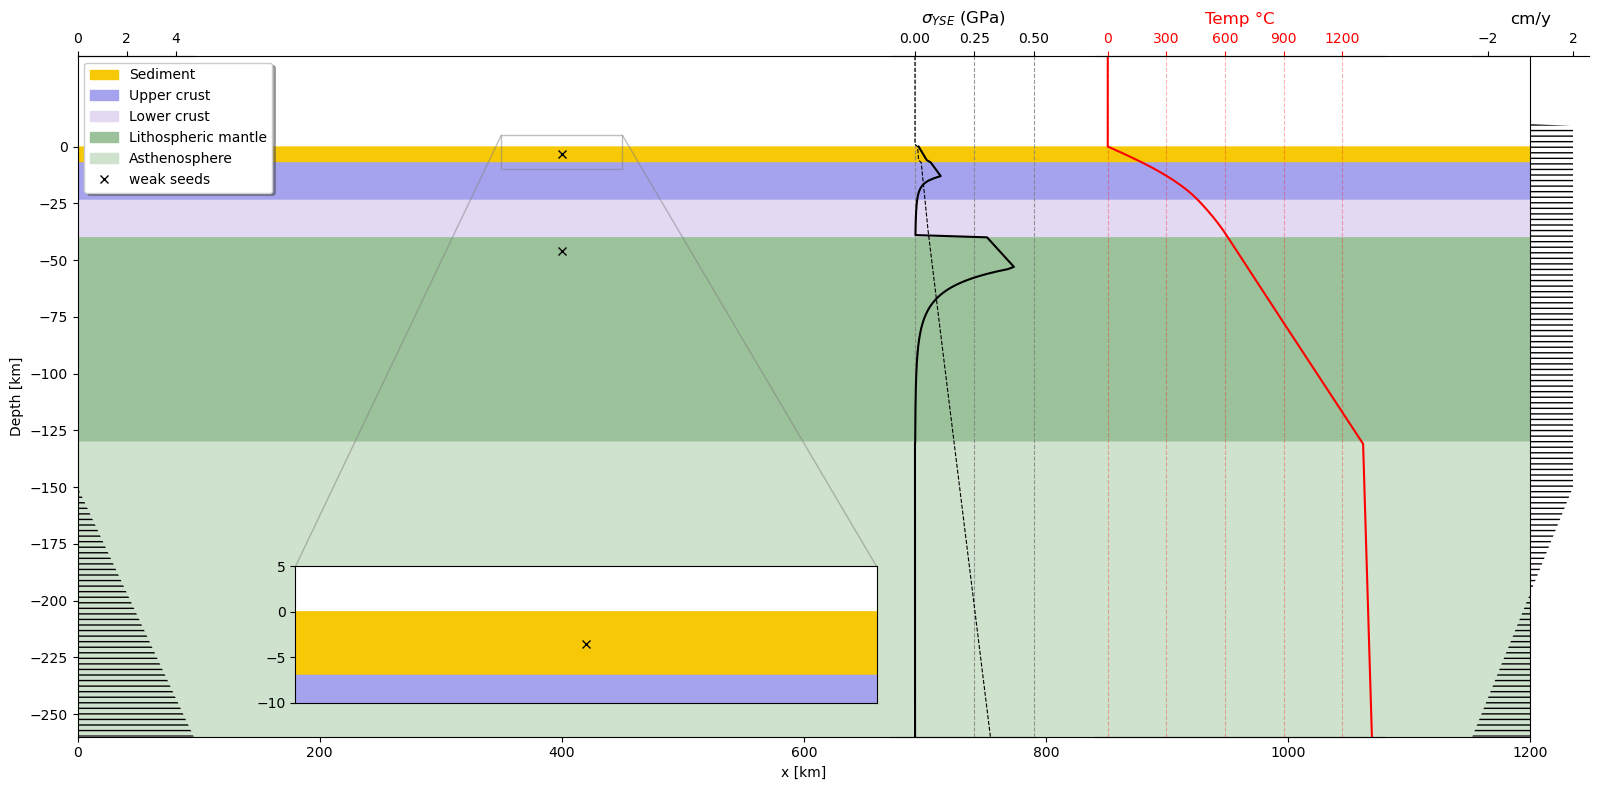

In [42]:
fig, ax = plt.subplots(figsize=(16, 8))
ylimplot = [(-Lz+t_sa) / 1e3, 0 + t_sa / 1e3]

#Basin Zoom
x1, x2, y1, y2 = (Lx/1e3)//3-50, (Lx/1e3)//3+50, -10, 5
axins = ax.inset_axes(
    [0.15, 0.05, 0.4, 0.2],
    xlim=(x1, x2), ylim=(y1, y2), xticks=[])



for ll in list(interfaces.items())[::-1]:
    label, layer = ll[0], ll[1]
    if 'seed' in label:
        continue


    if ('sed' in label) and (label!='sed0'):
        label='air'
        continue




    ax.fill_between(x/1e3, (-layer + t_sa) / 1e3, -Lz/1e3,color=colors[label],label=correct_labels[label])
    axins.fill_between(x/1e3, (-layer + t_sa) / 1e3, -Lz/1e3,color=colors[label],label=correct_labels[label])

ax.set_yticks(np.arange(-Lz / 1e3, 1 / 1e3, 25))
ax.set_xlim([0, Lx/1000])

ax.set_ylim(ylimplot)

ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

#plt.title("Interfaces")


#Velocity = Right side
vr_plot = max(abs(VX[:, -1]* (100*365 * 24 * 3600)))
fac = 0.96
axl = ax.inset_axes((fac,0,(1-fac)*2,1))
axl.fill_betweenx((-z + t_sa) / 1.0e3, VX[:, -1]* (100*365 * 24 * 3600), 0, color=None, facecolor=None, hatch='---',alpha=0)
axl.set_ylim(ylimplot)
axl.set_yticks([])
axl.set_xticks(np.round([-2, 2],1))
axl.patch.set_alpha(0)
axl.set_title('cm/y')
axl.xaxis.set_ticks_position('top')
#axl.tick_params(labelbottom=False,labeltop=True)
axl.set_xlim([-vr_plot, vr_plot])
axl.spines['left'].set_visible(False)
axl.spines['right'].set_visible(False)
axl.spines['bottom'].set_visible(False)


#Velocity = Left side
vr_plot = max(abs(VX[:, 0]* (100*365 * 24 * 3600)))
axr = ax.inset_axes((0,0,(1-fac)*2,1))
axr.fill_betweenx((-z + t_sa) / 1.0e3, VX[:, 0]* (100*365 * 24 * 3600), 0, color=None, facecolor=None, hatch='---',alpha=0)
axr.set_ylim(ylimplot)
axr.set_yticks([])
axr.set_xticks(np.round([-0, 2, 4],1))
axr.patch.set_alpha(0)
#axr.set_title('cm/y')
axr.xaxis.set_ticks_position('top')
#axr.tick_params(labelbottom=False,labeltop=True)
axr.set_xlim([0, vr_plot])
axr.spines['left'].set_visible(False)
axr.spines['right'].set_visible(False)
axr.spines['bottom'].set_visible(False)

#Temperature
axt = ax.inset_axes((3.5/5,0,0.2,1))
axt.plot(temp_z[:, 0], -(z - t_sa) / 1.0e3, "-r")
axt.grid(visible=True, axis='x',which='both',ls='--',color='red',alpha=0.3)
axt.set_ylim(ylimplot)
axt.set_yticks([])
axt.set_xticks(np.linspace(0,1200,5))
axt.patch.set_alpha(0)
axt.xaxis.set_ticks_position('top')
axt.set_yticks([])
axt.xaxis.label.set_color('red')
axt.tick_params(axis='x', colors='red')
axt.spines['left'].set_visible(False)
axt.spines['right'].set_visible(False)
axt.set_title('Temp °C',color='red')
#axt.spines['bottom'].set_visible(False)


#Weak seed
#seeds_coords = [[x_seed, sed_x_seed],[seed_depth+t_lower_crust+t_upper_crust,sed_seed_depth]] #mantle seed, sed seed
seeds_coords_plot = np.array(seeds_coords)/1e3
ax.plot(seeds_coords_plot[0],-seeds_coords_plot[1]+ t_sa/1e3,'kx',label='weak seeds')
axins.plot(seeds_coords_plot[0],-seeds_coords_plot[1]+ t_sa/1e3,'kx',label='weak seeds')


#yield strength envelope
sr = 1.0E-15 #strain rate - s-1
R = 8.314 #gas constant - J K−1 mol−1
P = rho[::-1].cumsum()[::-1]*-g*dz
sigma_max = c0 * np.cos(phi0*np.pi/180) + P * np.sin(phi0*np.pi/180)
sigma_min = c0 * np.cos(2*np.pi/180) + P * np.sin(2*np.pi/180)
TK = temp_z[:, 0] + 273
visc = C * A**(-1./n) * sr**((1.0-n)/n)*np.exp((Q + V*P)/(n*R*TK))
sigma_v = visc * sr
cond = sigma_v>sigma_max
sigma_v[cond]=sigma_max[cond]

axsg = ax.inset_axes((2.8/5,0,0.1,1))
axsg.plot(sigma_v/1e9,-(z-t_sa)/1e3,'k')
axsg.plot(sigma_min/1e9,-(z-t_sa)/1e3,'k--',lw=0.8)
axsg.grid(visible=True, axis='x',which='both',ls='--',color='gray',alpha=0.8)
axsg.set_xticks([0,0.25,0.5])
axsg.set_xlim(-0.1,0.51)
axsg.set_ylim(ylimplot)
axsg.set_yticks([])
axsg.patch.set_alpha(0)
axsg.xaxis.set_ticks_position('top')
axsg.spines['left'].set_visible(False)
axsg.spines['right'].set_visible(False)
axsg.set_title('$\sigma_{YSE}$ (GPa)')

ax.indicate_inset_zoom(axins, edgecolor="grey")
plt.legend(loc='upper left',shadow=True)

plt.tight_layout()
plt.show()
fig.savefig(f'interfaces.svg',dpi=300)
fig.savefig(f'interfaces.png',dpi=300)

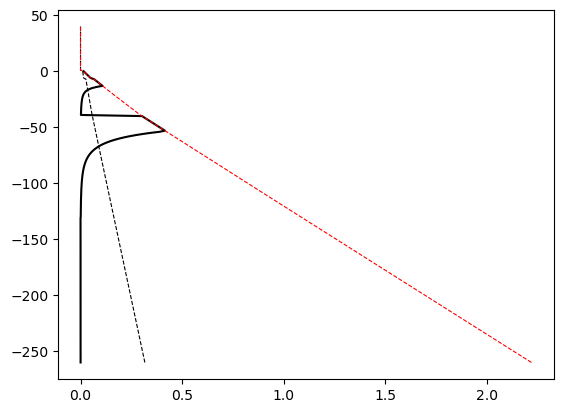

In [46]:
plt.plot(sigma_v/1e9,-(z-t_sa)/1e3,'k')
plt.plot(sigma_min/1e9,-(z-t_sa)/1e3,'k--',lw=0.8)
plt.plot(sigma_max/1.0E9,-(z-t_sa)/1e3,"r--",lw=0.8)

In [35]:
params = f"""
nx = {Nx}
nz = {Nz}
lx = {Lx}
lz = {Lz}


# Simulation options
multigrid                           = 1             # ok -> soon to be on the command line only
solver                              = direct        # default is direct [direct/iterative]
denok                               = 5.0e-15       # default is 1.0E-4
particles_per_element               = 61            # default is 81
particles_perturb_factor            = 0.7           # default is 0.5 [values are between 0 and 1]
rtol                                = 1.0e-7        # the absolute size of the residual norm (relevant only for iterative methods), default is 1.0E-5
RK4                                 = Euler         # default is Euler [Euler/Runge-Kutta]
Xi_min                              = 1.0e-6        # default is 1.0E-14
random_initial_strain               = 0.3           # default is 0.0
pressure_const                      = -1.0          # default is -1.0 (not used) - useful only in horizontal 2D models
initial_dynamic_range               = True          # default is False [True/False]
periodic_boundary                   = False         # default is False [True/False]
high_kappa_in_asthenosphere         = True          # default is False [True/False]
K_fluvial                           = 2.0e-7        # default is 2.0E-7
m_fluvial                           = 1.0           # default is 1.0
sea_level                           = 0.0           # default is 0.0
basal_heat                          = 0.0           # default is -1.0

# Surface processes
sp_surface_tracking                 = False          # default is False [True/False]
sp_surface_processes                = False         # default is False [True/False]
#sp_dt                               = 1.0e5         # default is 0.0  -No longer supported
sp_d_c                              = 1.0           # default is 0.0
plot_sediment                       = False         # default is False [True/False]
a2l                                 = True          # default is True [True/False]

free_surface_stab                   = True          # default is True [True/False]
theta_FSSA                          = 0.5           # default is 0.5 (only relevant when free_surface_stab = True)

# Time constrains
step_max                            = 15000         # Maximum time-step of the simulation
time_max                            = 50.0e6        # Maximum time of the simulation [years]
dt_max                              = 10.0e3         # Maximum time between steps of the simulation [years]
step_print                          = 50            # Make file every <step_print>
sub_division_time_step              = 0.5           # default is 1.0
initial_print_step                  = 0             # default is 0
initial_print_max_time              = 1.0e6         # default is 1.0E6 [years]

# Viscosity
viscosity_reference                 = 1.0e26        # Reference viscosity [Pa.s]
viscosity_max                       = 1.0e25        # Maximum viscosity [Pa.s]
viscosity_min                       = 1.0e18        # Minimum viscosity [Pa.s]
viscosity_per_element               = constant      # default is variable [constant/variable]
viscosity_mean_method               = arithmetic    # default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # default is depth [pressure/depth]

# External ASCII inputs/outputs
interfaces_from_ascii               = True          # default is False [True/False]
n_interfaces                        = {len(interfaces.keys())}          # Number of interfaces int the interfaces.txt file
variable_bcv                        = False         # default is False [True/False]
temperature_from_ascii              = True          # default is False [True/False]
velocity_from_ascii                 = True          # default is False [True/False]
binary_output                       = False         # default is False [True/False]
sticky_blanket_air                  = True          # default is False [True/False]
#precipitation_profile_from_ascii    = False         # default is False [True/False]  -No longer supported
#climate_change_from_ascii           = False         # default is False [True/False]  -No longer supported


print_step_files                    = False          # default is True [True/False]
checkered                           = True          # Print mora than one element in the print_step_files (default is False [True/False])

sp_mode                             = 5             # default is 1 [0/1/2]

geoq                                = on            # ok
geoq_fac                            = 100.0         # ok

# Physical parameters
temperature_difference              = 1500.         # ok
thermal_expansion_coefficient       = 3.28e-5       # ok
thermal_diffusivity_coefficient     = 1.0e-6        # ok
gravity_acceleration                = 10.0          # ok
density_mantle                      = 3300.         # ok
external_heat                       = 0.0e-12       # ok
heat_capacity                       = 1250.         # ok

non_linear_method                   = on            # ok
adiabatic_component                 = on            # ok
radiogenic_component                = on            # ok

# Velocity boundary conditions
top_normal_velocity                 = fixed         # ok
top_tangential_velocity             = free          # ok
bot_normal_velocity                 = fixed         # ok
bot_tangential_velocity             = free          # ok
left_normal_velocity                = fixed         # ok
left_tangential_velocity            = fixed         # ok
right_normal_velocity               = fixed         # ok
right_tangential_velocity           = fixed         # ok

surface_velocity                    = 0.0e-2        # ok
multi_velocity                      = False         # default is False [True/False]

# Temperature boundary conditions
top_temperature                     = fixed         # ok
bot_temperature                     = fixed         # ok
left_temperature                    = free         # ok - set free to variable diffusivity
right_temperature                   = free         # ok

rheology_model                      = 9             # ok
T_initial                           = 3             # ok

"""
# Create the parameter file
with open("param.txt", "w") as f:
    for line in params.split("\n"):
        f.write(" ".join(line.split()) + "\n")




In [36]:
'''
#!/bin/bash -v
#SBATCH --partition=SP3
#SBATCH --job-name=mandyocsalt+rift28 # Job name
#SBATCH --mail-type=BEGIN,END,FAIL # Mail events (NONE, BEGIN, END, FAIL, ALL)
#SBATCH --mail-user=jbueno@usp.br # Where to send mail
#SBATCH --nodes=5 # Run all processes on a single node
#SBATCH --ntasks=5 # Run a single task
#SBATCH --cpus-per-task=20 # Number of CPU cores per task
#SBATCH --time=8- # DD-HH:MM:SS # 16 horas; “2-” para 2 dias; máximo “8-”
#SBATCH --output=salt+rift28_%j.log # Standard output and error log

echo $SLURM_JOB_ID # ID of job allocation
echo $SLURM_SUBMIT_DIR # Directory job where was submitted
echo $SLURM_JOB_NODELIST # File containing allocated hostnames
echo $SLURM_NTASKS # Total number of cores for job

source /scratch/intel/oneapi/setvars.sh
source /scratch/intel/oneapi/mkl/2022.1.0/env/vars.sh

module unload openmpi
'''

'\n#!/bin/bash -v\n#SBATCH --partition=SP3\n#SBATCH --job-name=mandyocsalt+rift28 # Job name\n#SBATCH --mail-type=BEGIN,END,FAIL # Mail events (NONE, BEGIN, END, FAIL, ALL)\n#SBATCH --mail-user=jbueno@usp.br # Where to send mail\n#SBATCH --nodes=5 # Run all processes on a single node\n#SBATCH --ntasks=5 # Run a single task\n#SBATCH --cpus-per-task=20 # Number of CPU cores per task\n#SBATCH --time=8- # DD-HH:MM:SS # 16 horas; “2-” para 2 dias; máximo “8-”\n#SBATCH --output=salt+rift28_%j.log # Standard output and error log\n\necho $SLURM_JOB_ID # ID of job allocation\necho $SLURM_SUBMIT_DIR # Directory job where was submitted\necho $SLURM_JOB_NODELIST # File containing allocated hostnames\necho $SLURM_NTASKS # Total number of cores for job\n\nsource /scratch/intel/oneapi/setvars.sh\nsource /scratch/intel/oneapi/mkl/2022.1.0/env/vars.sh\n\nmodule unload openmpi\n'

In [37]:



nucleos = 16

run = '''#!/bin/bash -v
#SBATCH --partition=SP2
#SBATCH --job-name=mandyoc-{CEN}	  # Job name
#SBATCH --mail-type=BEGIN,END,FAIL    	# Mail events (NONE, BEGIN, END, FAIL, ALL)
#SBATCH --mail-user=jbueno@usp.br     	# Where to send mail
#SBATCH --nodes=1                       # Run all processes on a single node
#SBATCH --ntasks={NUCLEOS}              # Run a single task
#SBATCH --cpus-per-task=1               # Number of CPU cores per task
#SBATCH --time=8-                       # DD-HH:MM:SS   # 16 horas; “2-” para 2 dias; máximo “8-”
#SBATCH --output={CEN}_%j.log     # Standard output and error log

#source /scratch/intel/oneapi/setvars.sh
#source /scratch/intel/oneapi/mkl/2022.1.0/env/vars.sh

echo $SLURM_JOB_ID 			# ID of job allocation
echo $SLURM_SUBMIT_DIR 			# Directory job where was submitted
echo $SLURM_JOB_NODELIST 		# File containing allocated hostnames
echo $SLURM_NTASKS 			# Total number of cores for job



module unload openmpi

PETSC_DIR=/temporario2/10328088/petsc
PETSC_ARCH=v3.15.5-optimized

MANDYOC=/temporario2/10328088/mandyoc/bin/mandyoc
#MANDYOC_OPTIONS='-seed 0,2,12 -strain_seed 0.0,1.0,0.5'

${PETSC_DIR}/${PETSC_ARCH}/bin/mpiexec -n {NUCLEOS} ${MANDYOC} #${MANDYOC_OPTIONS}
  '''.format(CEN=cen, PETSC_DIR='PETSC_DIR',PETSC_ARCH='PETSC_ARCH',MANDYOC='MANDYOC',MANDYOC_OPTIONS='MANDYOC_OPTIONS',NUCLEOS=nucleos)


print(run)
with open("run.sh", "w") as f:
  for line in run.split("\n"):
      f.write(" ".join(line.split()) + "\n")

#!/bin/bash -v
#SBATCH --partition=SP2
#SBATCH --job-name=mandyoc-kc_0_7_40_2.0_ml_vc	  # Job name
#SBATCH --mail-type=BEGIN,END,FAIL    	# Mail events (NONE, BEGIN, END, FAIL, ALL)
#SBATCH --mail-user=jbueno@usp.br     	# Where to send mail
#SBATCH --nodes=1                       # Run all processes on a single node
#SBATCH --ntasks=16              # Run a single task
#SBATCH --cpus-per-task=1               # Number of CPU cores per task
#SBATCH --time=8-                       # DD-HH:MM:SS   # 16 horas; “2-” para 2 dias; máximo “8-”
#SBATCH --output=kc_0_7_40_2.0_ml_vc_%j.log     # Standard output and error log

#source /scratch/intel/oneapi/setvars.sh
#source /scratch/intel/oneapi/mkl/2022.1.0/env/vars.sh

echo $SLURM_JOB_ID 			# ID of job allocation
echo $SLURM_SUBMIT_DIR 			# Directory job where was submitted
echo $SLURM_JOB_NODELIST 		# File containing allocated hostnames
echo $SLURM_NTASKS 			# Total number of cores for job



module unload openmpi

PETSC_DIR=/temporario2/103280

In [38]:
#main_dir='/media/jobueno/STOV/cen_sys/300x1200-1kmv3'
#os.system(f"cp -r ../{tempdir}  {main_dir}/{cen}/")